In [1]:
import sys 
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from NN import network, activation_functions, loss_functions
from NN import ANN


/root/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Introduction 
This notebook was made as a base for the Neural Network implementation and tests. 
The target values for the net and output for each layers follows bellow: 
```
Input Layer:
[0.05, 0.10]

Hidden Layer:
Weigths [0.15, 0.2] [0.25, 0.3]
Net [0.3775 0.3925]
Out [0.59326999 0.59688438] (softmax)
Grad [[0.14978072 0.24950229] [0.19978072 0.29950229]]

Output Layer:
[[0.4, 0.45], [0.50, 0.55]]
Net [1.10590597 1.2249214 ]
Out [0.75136507 0.77292847]] (softmax)
Grad 



MSD = 0.2983711
```


In [2]:
# Target Values 
# Hidden Layer:
_NetH = np.array([[0.3775, 0.3925]])
_OutH = np.array([[0.59326999, 0.59688438]])

# Output Layer:
_NetO = np.array([[1.10590597, 1.2249214 ]])
_OutO = np.array([[0.75136507, 0.77292847]])

_MSD = 0.2983711
_error_accepted = 0.00000001

In [3]:
def compare_arrays(A, B, eps=_error_accepted): 
    return (A - B).sum() < eps

## Layer by Layer Validation
To identify if there is no code broken

In [4]:
from importlib import reload
reload(network)
I = np.array([[0.05, 0.10]])
W = np.array([[0.15, 0.2], [0.25, 0.3]]).T
h1 = network.Layer(2, 2, 'sigmoid', weights=W, bias=0.35, label="H1")
netH, outH =  h1.feed_forward(I)
print(netH)
print(outH)
assert(compare_arrays(netH, _NetH))
assert(compare_arrays(outH, _OutH))

[[0.3775 0.3925]]
[[0.59326999 0.59688438]]


In [5]:
from importlib import reload
reload(network)
I = np.array([[0.59326999, 0.59688438]])
W = np.array([[0.4, 0.45], [0.50, 0.55]]).T
o1 = network.Layer(2, 2, 'sigmoid', weights=W, bias=0.6, label="H1")
netO, outO =  o1.feed_forward(I)
print(netO)
print(outO)
assert(compare_arrays(netO, _NetO))
assert(compare_arrays(outO, _OutO))

[[1.10590597 1.2249214 ]]
[[0.75136507 0.77292847]]


# Convergence Checkings
Based on the sample given by the class teacher

## Manual Calculations

In [6]:
from importlib import reload
reload(network)
model = network.NN(loss='smd')
X = np.array([[0.05, 0.10]])

Wh = np.array([[0.15, 0.2], [0.25, 0.3]]).T
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]]).T
o = network.Layer(2, 2, 'sigmoid', weights=Wo, bias=0.6, label="H1")
model.add_layer(h)
model.add_layer(o)
model.show_weights()

Y, aY = model.feed_forward(X)
Y_, aY_ = ([1.10590597, 1.2249214 ], [0.75136507, 0.77292847])
print("Y\n",Y_)
print("\na(Y)\n",aY_)

assert(compare_arrays(Y, Y_))
assert(compare_arrays(aY, aY_))


Model Weights
-------------------------------
H1      (input=2, neurons=2, activation=sigmoid)
[[0.15 0.25]
 [0.2  0.3 ]]
H1      (input=2, neurons=2, activation=sigmoid)
[[0.4  0.5 ]
 [0.45 0.55]]
-------------------------------
Y
 [1.10590597, 1.2249214]

a(Y)
 [0.75136507, 0.77292847]


### Working on the back propagation

In [7]:
from importlib import reload
reload(network)
model.show_weights()
Y = np.array([0.01, 0.99])
Etotal = loss_functions.smd(aY, Y)
print(Etotal)
assert((Etotal - _MSD) < np.finfo(np.float32).eps)

Model Weights
-------------------------------
H1      (input=2, neurons=2, activation=sigmoid)
[[0.15 0.25]
 [0.2  0.3 ]]
H1      (input=2, neurons=2, activation=sigmoid)
[[0.4  0.5 ]
 [0.45 0.55]]
-------------------------------
0.2983711087600027


### Emulating the weights update for the layer O 

In [8]:
reload(loss_functions)
reload(activation_functions)
lr = 0.5
#Done - Partial
dEo_dw = loss_functions.smd_derivative_chain(outO, Y)
print(dEo_dw)

# Done
dOuto_Dneto = activation_functions.sigmoid_derivative_chain(outO)
print('dout',dOuto_Dneto)

# Done - Self.input
dNeto  = outH
print('dnet',dNeto) 
# Done
deltaO  = dEo_dw * dOuto_Dneto
print('delta', deltaO)

dWO = deltaO * outH
print('dw', dWO)
# Done
updateO = Wo - lr * dWO
print('update', updateO)

[[ 0.74136507 -0.21707153]]
dout [[0.1868156  0.17551005]]
dnet [[0.59326999 0.59688438]]
delta [[ 0.13849856 -0.03809824]]
dw [[ 0.08216704 -0.02274024]]
update [[0.35891648 0.51137012]
 [0.40891648 0.56137012]]


In [9]:
#
# Done - Partial
dEo_dOh = deltaO * Wo
dETotal_dOh = dEo_dOh.sum(axis=1)
print (dEo_dOh)
print('dETotal_dOh', dETotal_dOh)

# Done
dOuth_Dneth = activation_functions.sigmoid_derivative_chain(outH)
print('dOuth_Dneth', dOuth_Dneth)


# Done
deltaH = dETotal_dOh * dOuth_Dneth 
print('deltaH', deltaH)

# done
# self.input
dNeth_dw = X
dWh = deltaH * dNeth_dw
print('dWh', dWh)

# Done
updateH = Wh - lr * dWh
print('update', updateH)

[[ 0.05539942 -0.01904912]
 [ 0.06232435 -0.02095403]]
dETotal_dOh [0.03635031 0.04137032]
dOuth_Dneth [[0.24130071 0.24061342]]
deltaH [[0.00877135 0.00995425]]
dWh [[0.00043857 0.00099543]]
update [[0.14978072 0.24950229]
 [0.19978072 0.29950229]]


## Using the implemented Grad calculation for Layers

In [10]:
reload(loss_functions)
reload(activation_functions)
reload(network)
network.DEBUG = True

X = np.array([[0.05, 0.10], [0.05, 0.10]], np.float64)
Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]],  np.float64).T
o = network.Layer(2, 2, 'sigmoid', bias=0.6, weights=Wo, label="O")
Y = np.array([[0.01, 0.99], [0.01, 0.99]], np.float64)

for i in range(1):
    netH, outH = h.feed_forward(X)
    netO, outO = o.feed_forward(outH)

    
    Etotal = loss_functions.smd(outO, Y)
    if (i % 1000) == 0:
        print(i, 'error', Etotal)
    
    dEo_dw = loss_functions.smd_derivative_chain(outO, Y)
    
    network.dprint(dEo_dw)
    network.dprint ("")
    network.dprint ("==========================================")
    network.dprint ("Back Propagate Layer O")
    network.dprint ("==========================================")
    o.backpropagate(dETotal_dOut=dEo_dw)
    network.dprint ("==========================================")
    network.dprint ("")

    network.dprint ("==========================================")
    network.dprint ("Back Propagate Layer H")
    network.dprint ("==========================================")
    h.backpropagate(output_layer=o)
    network.dprint ("==========================================")

print (outO)

('net', array([[0.3775, 0.3925],
       [0.3775, 0.3925]]))
('out', array([[0.59326999, 0.59688438],
       [0.59326999, 0.59688438]]))
('net', array([[1.10590597, 1.2249214 ],
       [1.10590597, 1.2249214 ]]))
('out', array([[0.75136507, 0.77292847],
       [0.75136507, 0.77292847]]))
0 error 0.5967422175200054
[[ 0.74136507 -0.21707153]
 [ 0.74136507 -0.21707153]]

Back Propagate Layer O
('dETotal_dOut', array([[ 0.74136507, -0.21707153],
       [ 0.74136507, -0.21707153]]))

Back Propagate Layer H
('dETotal_dOut', None)
[[0.75136507 0.77292847]
 [0.75136507 0.77292847]]


# Using the Fit Methods with the full network calculation

## SMD as the Loss Function

In [11]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False
eps = 0.00001

X = np.array([[0.05, 0.10]], np.float64)
Y = np.array([[0.01, 0.99]], np.float64)

# Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 3, 'sigmoid', bias=0.35, label="H1")

# Wo = np.array([[0.4, 0.45], [0.50, 0.55]], np.float64).T
o = network.Layer(3, 2, 'sigmoid', bias=0.6, label="Output")

model = network.NN(loss='smd')
model.add_layer(h)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=50000, 
          lr=0.5, epsilon=eps, b_sz=2, 
          print_interval=2000)

_, Y_ = model.feed_forward(X)

mae = np.absolute(Y - Y_).mean()
print(Y_, mae)
assert(mae < 0.01)

Model Weights
-------------------------------
H1      (input=2, neurons=3, activation=sigmoid)
[[0.58928708 0.31946743 0.19430421]
 [0.70382379 0.61594013 0.1893582 ]]
Output  (input=3, neurons=2, activation=sigmoid)
[[0.6220154  0.00536593]
 [0.37833241 0.82050938]
 [0.32390615 0.97401024]]
-------------------------------
Shuffled
It: 2000 Batch: 1 Epoch 1999 Error: 0.00458758 lr: 0.500000 
It: 4000 Batch: 1 Epoch 3999 Error: 0.00014762 lr: 0.500000 
It: 6000 Batch: 1 Epoch 5999 Error: 0.00006194 lr: 0.500000 
It: 8000 Batch: 1 Epoch 7999 Error: 0.00003331 lr: 0.500000 
It: 10000 Batch: 1 Epoch 9999 Error: 0.00002011 lr: 0.500000 
It: 12000 Batch: 1 Epoch 11999 Error: 0.00001300 lr: 0.500000 
Finished 
 It: 12280 Batch: 1 Epoch 12279 Train Loss: 0.00001000 lr: 0.500000 
[[0.01316521 0.98684142]] 0.0031618985035960206


## Cross Entropy 

In [12]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False
eps = 0.0001
X = np.array([[0.05, 0.10]], np.float64)
Y = np.array([[0.01, 0.99]], np.float64)

Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]], np.float64).T
o = network.Layer(2, 2, 'sigmoid', weights=Wo, bias=0.6, label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=10000,
          lr=0.1, epsilon=eps, 
          print_interval=2000)

_, Y_ = model.feed_forward(X)

mae = np.absolute(Y - Y_).mean()
print(Y_, mae)
assert(mae < 0.01)

Model Weights
-------------------------------
H1      (input=2, neurons=2, activation=sigmoid)
[[0.15 0.25]
 [0.2  0.3 ]]
Output  (input=2, neurons=2, activation=sigmoid)
[[0.4  0.5 ]
 [0.45 0.55]]
-------------------------------
Shuffled
It: 2000 Batch: 1 Epoch 1999 Error: 0.76574643 lr: 0.100000 
It: 4000 Batch: 1 Epoch 3999 Error: 0.66248688 lr: 0.100000 
It: 6000 Batch: 1 Epoch 5999 Error: 0.65524647 lr: 0.100000 
It: 8000 Batch: 1 Epoch 7999 Error: 0.65246400 lr: 0.100000 
It: 10000 Batch: 1 Epoch 9999 Error: 0.65099797 lr: 0.100000 
Finished 
 It: 10000 Batch: 1 Epoch 9999 Train Loss: 0.65099797 lr: 0.100000 
[[0.0038555  0.99623122]] 0.006187855935083348


In [13]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False

eps = np.finfo(np.float32).eps

X = np.array([[0.05, 0.10], [0.05, 0.10], [0.10, 0.05]], np.float64)
Y = np.array([[0.0, 1], [0.0, 1], [1., 0.]], np.float64)

h1 = network.Layer(2, 10, 'sigmoid',  label="H1")
o = network.Layer(10, 2, 'sigmoid',  label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=50000, 
          lr=0.9, epsilon=eps,
          print_interval=2000)

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
Y = Y.argmax(axis=-1)
mae = np.absolute(Y - Y_).mean()
print(mae)
print(Y, Y_)
assert(mae < 0.1)

Model Weights
-------------------------------
H1      (input=2, neurons=10, activation=sigmoid)
[[0.91087306 0.7152556  0.95024787 0.37208203 0.08091375 0.38719568
  0.52685008 0.36185659 0.5722681  0.55743952]
 [0.74925603 0.08785126 0.79203021 0.87050807 0.09380903 0.96655817
  0.24648642 0.39673614 0.44527533 0.27825159]]
Output  (input=10, neurons=2, activation=sigmoid)
[[0.72794605 0.80913953]
 [0.18960451 0.02110783]
 [0.29791793 0.54728466]
 [0.6891351  0.99748403]
 [0.58063858 0.70113345]
 [0.07267078 0.13318688]
 [0.53803374 0.85392068]
 [0.47157369 0.95837203]
 [0.68284183 0.35319139]
 [0.73781131 0.82320848]]
-------------------------------
Shuffled
It: 2000 Batch: 2 Epoch 666 Error: 1.28706531 lr: 0.900000 
It: 4000 Batch: 1 Epoch 1333 Error: 1.28045564 lr: 0.900000 
It: 6000 Batch: 3 Epoch 1999 Error: 1.26108056 lr: 0.900000 
It: 8000 Batch: 2 Epoch 2666 Error: 0.96660454 lr: 0.900000 
It: 10000 Batch: 1 Epoch 3333 Error: 0.68298477 lr: 0.900000 
It: 12000 Batch: 3 Epoch 3

# Multi class Classification Test

In [14]:
nclasses = 3
nsamples = 60000
nfeatures = 128

eps = np.finfo(np.float128).eps


vals = dataset_helper.get_toy_data_multiclass(nclasses, nsamples, nfeatures)
X,  _, _, _ = vals

epoch_sz = X.shape[0]
lr = 0.5
max_iter = 5 * epoch_sz
print_interval = 20*1000
decay_iteractions= 1 * epoch_sz
decay_rate = 0.5

## Using Cross Entropy as the Loss Function

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=tanh)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 20000 Batch: 20000 Epoch 0 Train Loss: 1.50146461 lr: 0.500000 Val Loss: 1.42569952 Val Acc 0.74266667
It: 40000 Batch: 40000 Epoch 0 Train Loss: 1.42671506 lr: 0.500000 Val Loss: 1.41503096 Val Acc 0.73183333
It: 60000 Batch: 12000 Epoch 1 Train Loss: 1.41259469 lr: 0.250000 Val Loss: 1.40070667 Val Acc 0.74700000
It: 80000 Batch: 32000 Epoch 1 Train Loss: 1.39585156 lr: 0.250000 Val Loss: 1.39274079 Val Acc 0.75358333
It: 100000 Batch: 4000 Epoch 2 Train Loss: 1.38770135 lr: 0.125000 Val Loss: 1.38361342 Val Acc 0.75633333
It: 120000 Batch: 24000 Epoch 2 Train Loss: 1.38722262 lr: 0.125000 Val Loss: 1.38571617 Val Acc 0.75025000
It: 140000 Batch: 44000 Epoch 2 Train Loss: 1.38761129 lr: 0.125000 Val Loss: 1.38538991 Val Acc 0.74608333
It: 160000 Batch: 16000 Epoch 3 Train Loss: 1.39093647 lr: 0.0

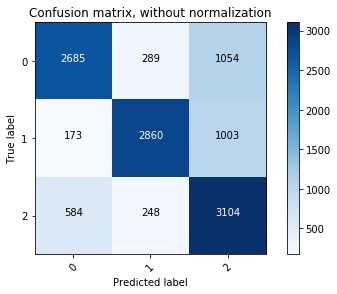

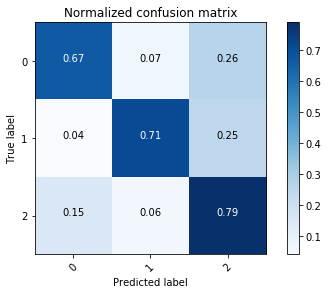

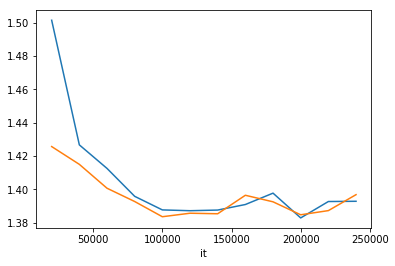

In [15]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'tanh',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=sigmoid)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 20000 Batch: 20000 Epoch 0 Train Loss: 1.57989933 lr: 0.500000 Val Loss: 1.42074366 Val Acc 0.74991667
It: 40000 Batch: 40000 Epoch 0 Train Loss: 1.39781429 lr: 0.500000 Val Loss: 1.36951679 Val Acc 0.76091667
It: 60000 Batch: 12000 Epoch 1 Train Loss: 1.36214796 lr: 0.250000 Val Loss: 1.34267331 Val Acc 0.77025000
It: 80000 Batch: 32000 Epoch 1 Train Loss: 1.33658842 lr: 0.250000 Val Loss: 1.32379044 Val Acc 0.76600000
It: 100000 Batch: 4000 Epoch 2 Train Loss: 1.30896903 lr: 0.125000 Val Loss: 1.31231268 Val Acc 0.77266667
It: 120000 Batch: 24000 Epoch 2 Train Loss: 1.29948356 lr: 0.125000 Val Loss: 1.31088851 Val Acc 0.77358333
It: 140000 Batch: 44000 Epoch 2 Train Loss: 1.30385143 lr: 0.125000 Val Loss: 1.30242857 Val Acc 0.77650000
It: 160000 Batch: 16000 Epoch 3 Train Loss: 1.28247396 lr: 

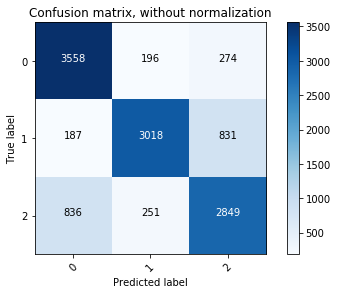

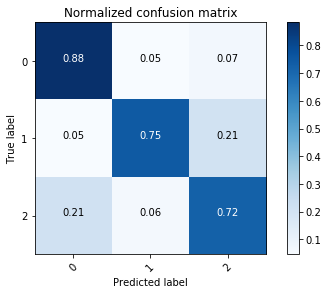

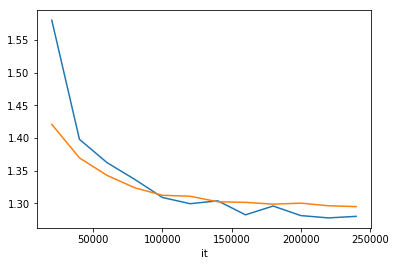

In [16]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

eps = np.finfo(np.float32).eps

h1 = network.Layer(nfeatures, 64, 'sigmoid',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=relu)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled


../NN/activation_functions.py:18: RuntimeWarning: overflow encountered in exp
  sig = 1. / (1. + np.exp(-h))


It: 20000 Batch: 20000 Epoch 0 Train Loss: 1.72068292 lr: 0.500000 Val Loss: 1.64871125 Val Acc 0.59741667
It: 40000 Batch: 40000 Epoch 0 Train Loss: 1.69885583 lr: 0.500000 Val Loss: 1.66344645 Val Acc 0.56475000
It: 60000 Batch: 12000 Epoch 1 Train Loss: 1.68004111 lr: 0.250000 Val Loss: 1.68227909 Val Acc 0.56841667
It: 80000 Batch: 32000 Epoch 1 Train Loss: 1.69123779 lr: 0.250000 Val Loss: 1.68080446 Val Acc 0.55850000
It: 100000 Batch: 4000 Epoch 2 Train Loss: 1.66937280 lr: 0.125000 Val Loss: 1.66320785 Val Acc 0.56783333
It: 120000 Batch: 24000 Epoch 2 Train Loss: 1.66375610 lr: 0.125000 Val Loss: 1.63875988 Val Acc 0.58233333
It: 140000 Batch: 44000 Epoch 2 Train Loss: 1.64875394 lr: 0.125000 Val Loss: 1.62786675 Val Acc 0.60316667
It: 160000 Batch: 16000 Epoch 3 Train Loss: 1.62804602 lr: 0.062500 Val Loss: 1.61579884 Val Acc 0.61491667
It: 180000 Batch: 36000 Epoch 3 Train Loss: 1.61817519 lr: 0.062500 Val Loss: 1.61039253 Val Acc 0.61325000
It: 200000 Batch: 8000 Epoch 4 Tr

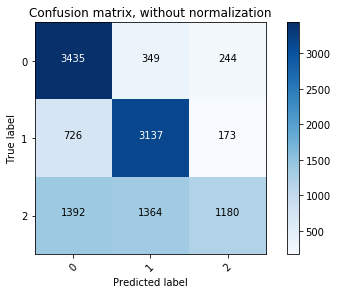

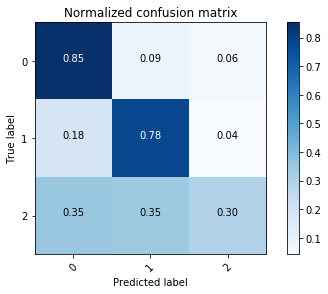

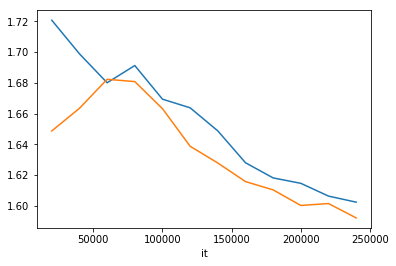

In [17]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)


network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'relu',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

## Using SMD 

In [18]:
print_interval=100

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=tanh)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 100 Batch: 100 Epoch 0 Train Loss: 0.69726391 lr: 0.500000 Val Loss: 0.63849580 Val Acc 0.42616667
It: 200 Batch: 200 Epoch 0 Train Loss: 0.55497817 lr: 0.500000 Val Loss: 0.47891714 Val Acc 0.51966667
It: 300 Batch: 300 Epoch 0 Train Loss: 0.45351096 lr: 0.500000 Val Loss: 0.41132913 Val Acc 0.60133333
It: 400 Batch: 400 Epoch 0 Train Loss: 0.39520878 lr: 0.500000 Val Loss: 0.35623751 Val Acc 0.62050000
It: 500 Batch: 500 Epoch 0 Train Loss: 0.28673784 lr: 0.500000 Val Loss: 0.30349931 Val Acc 0.62308333
Finished 
 It: 542 Batch: 542 Epoch 0 Train Loss: 0.00000006 lr: 0.500000 Val Loss: 0.30349931
6
Time Spent  3.381623552999997
Validation Stats...
Accuracy: 0.632
Precision: 0.637
Recall: 0.630
F1 Score: 0.633165
{0: 0, 1: 1, 2: 2}
Confusion matrix, without normalization
Normalized confusion matri

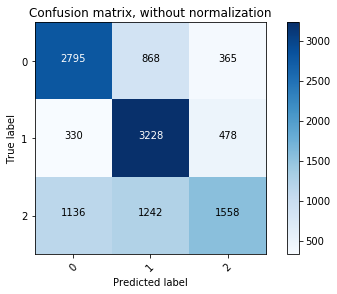

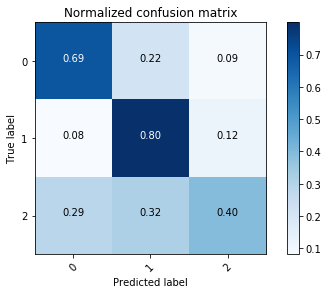

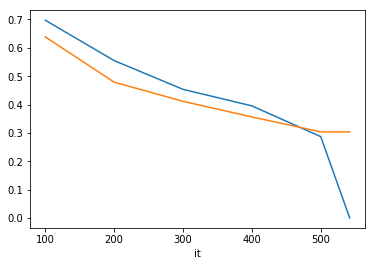

In [19]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'tanh',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='smd')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=sigmoid)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 100 Batch: 100 Epoch 0 Train Loss: 0.85375917 lr: 0.500000 Val Loss: 0.87020305 Val Acc 0.35950000
It: 200 Batch: 200 Epoch 0 Train Loss: 0.86367586 lr: 0.500000 Val Loss: 0.86168599 Val Acc 0.36183333
It: 300 Batch: 300 Epoch 0 Train Loss: 0.86039763 lr: 0.500000 Val Loss: 0.85000644 Val Acc 0.36891667
It: 400 Batch: 400 Epoch 0 Train Loss: 0.87414215 lr: 0.500000 Val Loss: 0.83427813 Val Acc 0.38325000
It: 500 Batch: 500 Epoch 0 Train Loss: 0.84525298 lr: 0.500000 Val Loss: 0.81117876 Val Acc 0.40700000
It: 600 Batch: 600 Epoch 0 Train Loss: 0.78760739 lr: 0.500000 Val Loss: 0.64490839 Val Acc 0.35566667
It: 700 Batch: 700 Epoch 0 Train Loss: 0.50841437 lr: 0.500000 Val Loss: 0.33377213 Val Acc 0.51233333
It: 800 Batch: 800 Epoch 0 Train Loss: 0.35315758 lr: 0.500000 Val Loss: 0.32975728 Val A

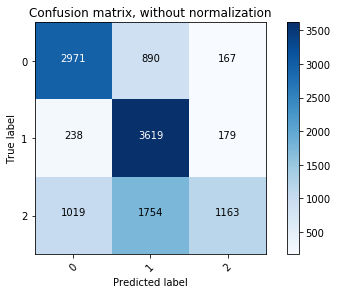

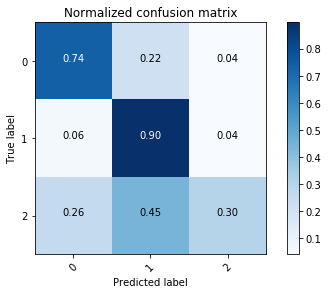

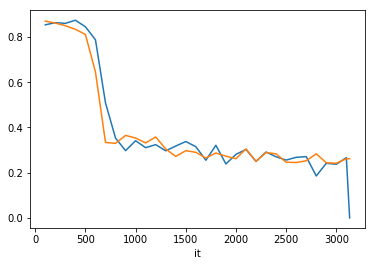

In [20]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'sigmoid',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='smd')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=relu)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 375 Batch: 375 Epoch 0 Train Loss: 0.84394016 lr: 0.100000 Val Loss: 0.84893659 Val Acc 0.33250000
It: 750 Batch: 750 Epoch 0 Train Loss: 0.83991236 lr: 0.050000 Val Loss: 0.82733229 Val Acc 0.33508333
It: 1125 Batch: 1125 Epoch 0 Train Loss: 0.81680155 lr: 0.025000 Val Loss: 0.80838964 Val Acc 0.34550000
It: 1500 Batch: 1500 Epoch 0 Train Loss: 0.79446064 lr: 0.012500 Val Loss: 0.78870918 Val Acc 0.35733333
It: 1875 Batch: 1875 Epoch 0 Train Loss: 0.76422587 lr: 0.006250 Val Loss: 0.76875732 Val Acc 0.35516667
Finished 
 It: 1875 Batch: 1875 Epoch 0 Train Loss: 0.76422587 lr: 0.006250 Val Loss: 0.76875732
6
Time Spent  2.057496088999983
Validation Stats...
Accuracy: 0.355
Precision: 0.364
Recall: 0.353
F1 Score: 0.358409
{0: 0, 1: 1, 2: 2}
Confusion matrix, without normalization
Normalized confusi

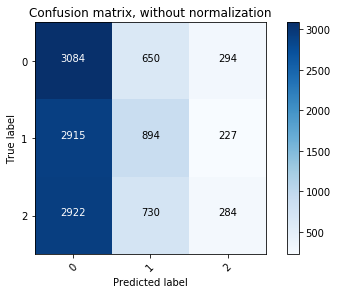

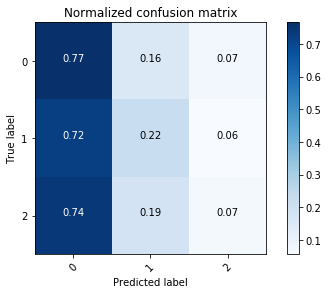

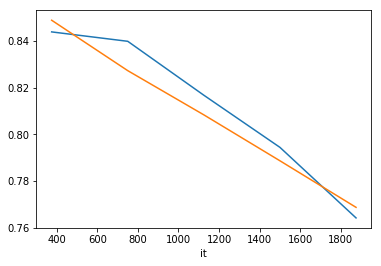

In [26]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'relu',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='smd')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

## Batch Update Tests

In [22]:
lr = 0.1
b_sz = 128
decay_iteractions = 1 * (epoch_sz // b_sz) 
max_iter = 5 * (epoch_sz // b_sz) 
print_interval = (epoch_sz // b_sz) 

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=tanh)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 375 Batch: 375 Epoch 0 Train Loss: 1.81711368 lr: 0.100000 Val Loss: 1.81692663 Val Acc 0.51700000
It: 750 Batch: 375 Epoch 1 Train Loss: 1.81750566 lr: 0.050000 Val Loss: 1.81777280 Val Acc 0.51400000
It: 1125 Batch: 375 Epoch 2 Train Loss: 1.81741280 lr: 0.025000 Val Loss: 1.81789454 Val Acc 0.51366667
It: 1500 Batch: 375 Epoch 3 Train Loss: 1.81739765 lr: 0.012500 Val Loss: 1.81789082 Val Acc 0.51291667
It: 1875 Batch: 375 Epoch 4 Train Loss: 1.81754296 lr: 0.006250 Val Loss: 1.81771236 Val Acc 0.51341667
Finished 
 It: 1875 Batch: 375 Epoch 4 Train Loss: 1.81754296 lr: 0.006250 Val Loss: 1.81771236
6
Time Spent  28.01676408


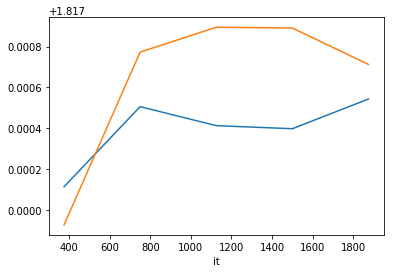

In [23]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)



network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'tanh',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = b_sz,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores

iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=relu)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 375 Batch: 375 Epoch 0 Train Loss: 1.86519140 lr: 0.100000 Val Loss: 1.83408786 Val Acc 0.59358333
It: 750 Batch: 375 Epoch 1 Train Loss: 1.82015899 lr: 0.050000 Val Loss: 1.81053105 Val Acc 0.61775000
It: 1125 Batch: 375 Epoch 2 Train Loss: 1.80553591 lr: 0.025000 Val Loss: 1.80180124 Val Acc 0.63008333
It: 1500 Batch: 375 Epoch 3 Train Loss: 1.79797306 lr: 0.012500 Val Loss: 1.79909526 Val Acc 0.63350000
It: 1875 Batch: 375 Epoch 4 Train Loss: 1.79495256 lr: 0.006250 Val Loss: 1.79595288 Val Acc 0.65958333
Finished 
 It: 1875 Batch: 375 Epoch 4 Train Loss: 1.79495256 lr: 0.006250 Val Loss: 1.79595288
6
Time Spent  19.34725111200001


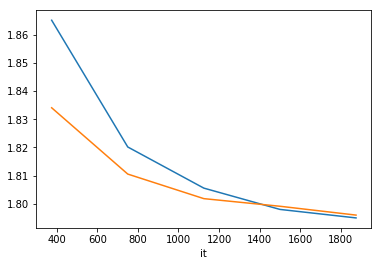

In [24]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)



network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'relu',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = b_sz,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores

iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=sigmoid)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 375 Batch: 375 Epoch 0 Train Loss: 1.86181175 lr: 0.100000 Val Loss: 1.82275625 Val Acc 0.66391667
It: 750 Batch: 375 Epoch 1 Train Loss: 1.79466698 lr: 0.050000 Val Loss: 1.77136771 Val Acc 0.66925000
It: 1125 Batch: 375 Epoch 2 Train Loss: 1.76357478 lr: 0.025000 Val Loss: 1.75745241 Val Acc 0.67775000
It: 1500 Batch: 375 Epoch 3 Train Loss: 1.75468744 lr: 0.012500 Val Loss: 1.75195429 Val Acc 0.68466667
It: 1875 Batch: 375 Epoch 4 Train Loss: 1.74998856 lr: 0.006250 Val Loss: 1.74852053 Val Acc 0.68650000
Finished 
 It: 1875 Batch: 375 Epoch 4 Train Loss: 1.74998856 lr: 0.006250 Val Loss: 1.74852053
6
Time Spent  24.101571035999996


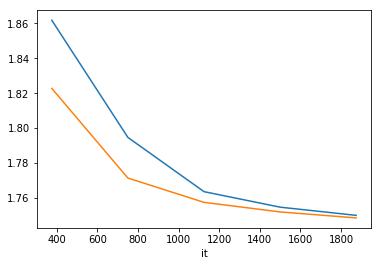

In [25]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)



network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'sigmoid',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = b_sz,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores

iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()